In [19]:
import os
import sys
import numpy as np
import keras
# from sklearn.model_selection import train_test_split

In [20]:
seed = 273
kinase = 'hgfr'

In [21]:
#import data
smiles_lines_train = [line.strip().split(',') for line in open(os.path.join('smiles_cluster_split', kinase+'_smiles_train.csv'))]
smiles_lines_val = [line.strip().split(',') for line in open(os.path.join('smiles_cluster_split', kinase+'_smiles_val.csv'))]
smiles_lines_test = [line.strip().split(',') for line in open(os.path.join('smiles_cluster_split', kinase+'_smiles_test.csv'))]
smiles_lines = smiles_lines_train + smiles_lines_val + smiles_lines_test
smiles = [line[1] for line in smiles_lines]

fingerprint_lines_train = [line.strip().split(',') for line in open(os.path.join('fingerprint_cluster_split', kinase+'_fingerprints_train.csv'))]
fingerprint_lines_val = [line.strip().split(',') for line in open(os.path.join('fingerprint_cluster_split', kinase+'_fingerprints_val.csv'))]
fingerprint_lines_test = [line.strip().split(',') for line in open(os.path.join('fingerprint_cluster_split', kinase+'_fingerprints_test.csv'))]
fingerprint_lines =  fingerprint_lines_train + fingerprint_lines_val + fingerprint_lines_test
fingerprints = [line[2:] for line in fingerprint_lines]
X_fingerprints = np.asarray(fingerprints, dtype=np.int16)
y = np.asarray([int(line[2]) for line in smiles_lines], dtype=np.int8)

In [22]:
#pad smiles with '!' to ensure equal length
max_smiles_len = max(len(s) for s in smiles)
smiles = [s + '!'*(max_smiles_len + 1 - len(s)) for s in smiles]

In [23]:
#one-hot vector representation of smiles
char_set = set()
for s in smiles:
    for c in s:
        char_set.add(c)
char_set = list(char_set)
char_to_index = {char_set[i]: i for i in range(len(char_set))}

X_smiles = np.zeros((len(smiles), max_smiles_len + 1, len(char_set)))
for i in range(len(smiles)):
    code = smiles[i]
    for j in range(len(code)):
        char = code[j]
        X_smiles[i, j, char_to_index[char]] = 1        

In [24]:
print(X_fingerprints.shape)
print(X_smiles.shape)
print(y.shape)

(2145, 4096)
(2145, 147, 38)
(2145,)


In [25]:
#train val test split
n_tot = y.shape[0]
indices = np.arange(n_tot, dtype=int)
n_train = len(smiles_lines_train)
n_val = len(smiles_lines_val)
n_test = len(smiles_lines_test)
indices_train = indices[:n_train]
indices_val = indices[n_train:n_train+n_val]
indices_test = indices[n_train+n_val:]
X_fingerprints_train = X_fingerprints[indices_train]
print(X_fingerprints_train.shape)
X_smiles_train = X_smiles[indices_train]
print(X_smiles_train.shape)
y_train = y[indices_train]
print(y_train.shape)
X_fingerprints_val = X_fingerprints[indices_val]
print(X_fingerprints_val.shape)
X_smiles_val = X_smiles[indices_val]
print(X_smiles_val.shape)
y_val = y[indices_val]
print(y_val.shape)
X_fingerprints_test = X_fingerprints[indices_test]
print(X_fingerprints_test.shape)
X_smiles_test = X_smiles[indices_test]
print(X_smiles_test.shape)
y_test = y[indices_test]
print(y_test.shape)
smiles_input_shape = X_smiles_train.shape[1:]
fingerprints_input_shape = X_fingerprints_train.shape[1:]

(1687, 4096)
(1687, 147, 38)
(1687,)
(229, 4096)
(229, 147, 38)
(229,)
(229, 4096)
(229, 147, 38)
(229,)


In [26]:
#check GPU presence
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

[]


In [27]:
#keras imports
from keras.models import Sequential
from keras.layers import TimeDistributed, GlobalAveragePooling2D, Activation, Dense, Input, Bidirectional
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback, EarlyStopping
from keras.layers import Dropout, Flatten
from keras.layers import concatenate, average
from keras import regularizers
from keras import initializers
from keras import constraints
from keras.models import Model
# Backend
from keras import backend as K
# Utils
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file
from keras import metrics

In [28]:
#F1 score computation
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
npzfile = np.load('mlp_cluster_' + kinase + '.npz')
pred_train_mlp, pred_val_mlp, pred_test_mlp = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_mlp_train, tpr_mlp_train, _ = roc_curve(y_train, pred_train_mlp)
auc_train = roc_auc_score(y_train, pred_train_mlp)
fpr_mlp_val, tpr_mlp_val, _ = roc_curve(y_val, pred_val_mlp)
auc_val = roc_auc_score(y_val, pred_val_mlp)
fpr_mlp_test, tpr_mlp_test, _ = roc_curve(y_test, pred_test_mlp)
auc_test = roc_auc_score(y_test, pred_test_mlp)
print('MLP Train AUC: %s' % auc_train)
print('MLP Val AUC: %s' % auc_val)
print('MLP Test AUC: %s' % auc_test)

MLP Train AUC: 0.996064249811573
MLP Val AUC: 0.6210826210826211
MLP Test AUC: 0.6393779342723005


In [30]:
npzfile = np.load('rnn_cluster_' + kinase + '.npz')
pred_train_rnn, pred_val_rnn, pred_test_rnn = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_train, tpr_rnn_train, _ = roc_curve(y_train, pred_train_rnn)
auc_train = roc_auc_score(y_train, pred_train_rnn)
fpr_rnn_val, tpr_rnn_val, _ = roc_curve(y_val, pred_val_rnn)
auc_val = roc_auc_score(y_val, pred_val_rnn)
fpr_rnn_test, tpr_rnn_test, _ = roc_curve(y_test, pred_test_rnn)
auc_test = roc_auc_score(y_test, pred_test_rnn)
print('RNN Train AUC: %s' % auc_train)
print('RNN Val AUC: %s' % auc_val)
print('RNN Test AUC: %s' % auc_test)

RNN Train AUC: 0.7173098136695567
RNN Val AUC: 0.4106125356125356
RNN Test AUC: 0.27582159624413144


In [31]:
pred_train_gcn = [float(line.strip().split(',')[0]) for line in open(os.path.join('result', kinase, 'train_pred_' + kinase + '.csv'))]
pred_val_gcn = [float(line.strip().split(',')[0]) for line in open(os.path.join('result', kinase, 'val_pred_' + kinase + '.csv'))]
pred_test_gcn = [float(line.strip()) for line in open(os.path.join('result_old', kinase, 'test_pred_' + kinase + '.csv'))]
y_train_gcn = [int(line.strip().split(', ')[1]) for line in open(os.path.join('result', kinase, 'train_pred_' + kinase + '.csv'))]
y_val_gcn = [int(line.strip().split(', ')[1]) for line in open(os.path.join('result', kinase, 'val_pred_' + kinase + '.csv'))]
fpr_gcn_train, tpr_gcn_train, _ = roc_curve(y_train_gcn, pred_train_gcn)
auc_train = roc_auc_score(y_train_gcn, pred_train_gcn)
fpr_gcn_val, tpr_gcn_val, _ = roc_curve(y_val_gcn, pred_val_gcn)
auc_val = roc_auc_score(y_val_gcn, pred_val_gcn)
fpr_gcn_test, tpr_gcn_test, _ = roc_curve(y_test, pred_test_gcn)
auc_test = roc_auc_score(y_test, pred_test_gcn)
print('GCN Train AUC: %s' % auc_train)
print('GCN Val AUC: %s' % auc_val)
print('GCN Test AUC: %s' % auc_test)

GCN Train AUC: 0.8715821678321677
GCN Val AUC: 0.4626068376068376
GCN Test AUC: 0.28433098591549294


In [32]:
npzfile = np.load('rnn_mlp_early_cluster_' + kinase + '.npz')
pred_train_mlp_rnn_early, pred_val_mlp_rnn_early, pred_test_mlp_rnn_early = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_mlp_early_train, tpr_rnn_mlp_early_train, _ = roc_curve(y_train, pred_train_mlp_rnn_early)
auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_early)
fpr_rnn_mlp_early_val, tpr_rnn_mlp_early_val, _ = roc_curve(y_val, pred_val_mlp_rnn_early)
auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_early)
fpr_rnn_mlp_early_test, tpr_rnn_mlp_early_test, _ = roc_curve(y_test, pred_test_mlp_rnn_early)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_early)
print('RNN+MLP Early Fusion Train AUC: %s' % auc_train)
print('RNN+MLP Early Fusion Val AUC: %s' % auc_val)
print('RNN+MLP Early Fusion Test AUC: %s' % auc_test)

RNN+MLP Early Fusion Train AUC: 0.9900445735563508
RNN+MLP Early Fusion Val AUC: 0.6388888888888888
RNN+MLP Early Fusion Test AUC: 0.6384976525821596


In [33]:
npzfile = np.load('rnn_mlp_late_cluster_' + kinase + '.npz')
pred_train_mlp_rnn_late, pred_val_mlp_rnn_late, pred_test_mlp_rnn_late = npzfile['pred_train'], npzfile['pred_val'], npzfile['pred_test']
fpr_rnn_mlp_late_train, tpr_rnn_mlp_late_train, _ = roc_curve(y_train, pred_train_mlp_rnn_late)
auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_late)
fpr_rnn_mlp_late_val, tpr_rnn_mlp_late_val, _ = roc_curve(y_val, pred_val_mlp_rnn_late)
auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_late)
fpr_rnn_mlp_late_test, tpr_rnn_mlp_late_test, _ = roc_curve(y_test, pred_test_mlp_rnn_late)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_late)
print('RNN+MLP Late Fusion Train AUC: %s' % auc_train)
print('RNN+MLP Late Fusion Val AUC: %s' % auc_val)
print('RNN+MLP Late Fusion Test AUC: %s' % auc_test)

RNN+MLP Late Fusion Train AUC: 0.9882052280339219
RNN+MLP Late Fusion Val AUC: 0.527065527065527
RNN+MLP Late Fusion Test AUC: 0.5220070422535211


In [34]:
pred_train_mlp_rnn_ens = (pred_train_mlp + pred_train_rnn)/2.
pred_val_mlp_rnn_ens = (pred_val_mlp + pred_val_rnn)/2.
pred_test_mlp_rnn_ens = (pred_test_mlp + pred_test_rnn)/2.
fpr_rnn_mlp_ens_train, tpr_rnn_mlp_ens_train, _ = roc_curve(y_train, pred_train_mlp_rnn_ens)
auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_ens)
fpr_rnn_mlp_ens_val, tpr_rnn_mlp_ens_val, _ = roc_curve(y_val, pred_val_mlp_rnn_ens)
auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_ens)
fpr_rnn_mlp_ens_test, tpr_rnn_mlp_ens_test, _ = roc_curve(y_test, pred_test_mlp_rnn_ens)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_ens)
print('RNN+MLP Ensemble Train AUC: %s' % auc_train)
print('RNN+MLP Ensemble Val AUC: %s' % auc_val)
print('RNN+MLP Ensemble Test AUC: %s' % auc_test)

RNN+MLP Ensemble Train AUC: 0.9915994070169659
RNN+MLP Ensemble Val AUC: 0.48326210826210825
RNN+MLP Ensemble Test AUC: 0.45539906103286387


In [35]:
# pred_train_mlp_rnn_gcn_ens = (pred_train_mlp + pred_train_rnn + pred_train_gcn)/3.
# pred_val_mlp_rnn_gcn_ens = (pred_val_mlp + pred_val_rnn + pred_val_gcn)/3.
pred_test_mlp_rnn_gcn_ens = (pred_test_mlp + pred_test_rnn + pred_test_gcn)/3.
# fpr_rnn_mlp_gcn_ens_train, tpr_rnn_mlp_gcn_ens_train, _ = roc_curve(y_train, pred_train_mlp_rnn_gcn_ens)
# auc_train = roc_auc_score(y_train, pred_train_mlp_rnn_gcn_ens)
# fpr_rnn_mlp_gcn_ens_val, tpr_rnn_mlp_gcn_ens_val, _ = roc_curve(y_val, pred_val_mlp_rnn_gcn_ens)
# auc_val = roc_auc_score(y_val, pred_val_mlp_rnn_gcn_ens)
fpr_rnn_mlp_gcn_ens_test, tpr_rnn_mlp_gcn_ens_test, _ = roc_curve(y_test, pred_test_mlp_rnn_gcn_ens)
auc_test = roc_auc_score(y_test, pred_test_mlp_rnn_gcn_ens)
# print('RNN+MLP+GCN Ensemble Train AUC: %s' % auc_train)
# print('RNN+MLP+GCN Ensemble Val AUC: %s' % auc_val)
print('RNN+MLP+GCN Ensemble Test AUC: %s' % auc_test)

RNN+MLP+GCN Ensemble Test AUC: 0.3512323943661972


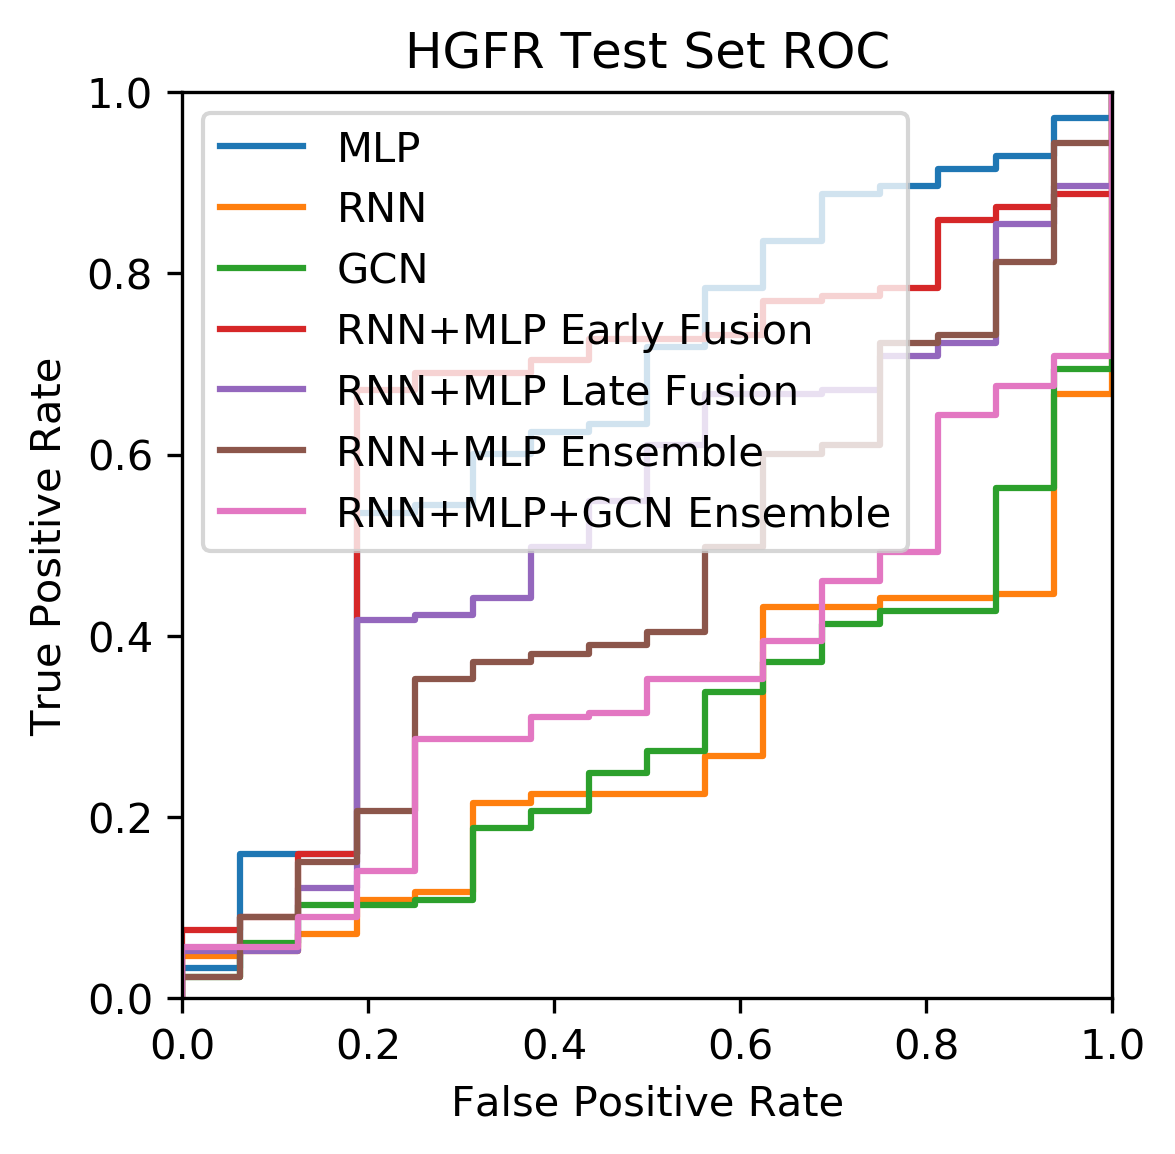

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
fig1 = plt.figure(figsize=(4,4), dpi=300)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s Test Set ROC' % kinase.upper())
plt.xlim(0,1)
plt.ylim(0,1)
plt_mlp, = plt.plot(fpr_mlp_test, tpr_mlp_test, label='MLP')
plt_rnn, = plt.plot(fpr_rnn_test, tpr_rnn_test, label='RNN')
plt_gcn, = plt.plot(fpr_gcn_test, tpr_gcn_test, label='GCN')
plt_rnn_mlp_early, = plt.plot(fpr_rnn_mlp_early_test, tpr_rnn_mlp_early_test, label='RNN+MLP Early Fusion')
plt_rnn_mlp_late, = plt.plot(fpr_rnn_mlp_late_test, tpr_rnn_mlp_late_test, label='RNN+MLP Late Fusion')
plt_rnn_mlp_ens, = plt.plot(fpr_rnn_mlp_ens_test, tpr_rnn_mlp_ens_test, label='RNN+MLP Ensemble')
plt_rnn_mlp_gcn_ens, = plt.plot(fpr_rnn_mlp_gcn_ens_test, tpr_rnn_mlp_gcn_ens_test, label='RNN+MLP+GCN Ensemble')
plt.legend(handles=[plt_mlp, plt_rnn, plt_gcn, plt_rnn_mlp_early, plt_rnn_mlp_late, plt_rnn_mlp_ens, plt_rnn_mlp_gcn_ens])
fig1.savefig(os.path.join('curves', kinase + '_AUC.png'), bbox_inches='tight')
plt.show()

In [37]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
p_mlp_train, r_mlp_train, _ = precision_recall_curve(y_train, pred_train_mlp)
aps_train = average_precision_score(y_train, pred_train_mlp)
p_mlp_val, r_mlp_val, _ = precision_recall_curve(y_val, pred_val_mlp)
aps_val = average_precision_score(y_val, pred_val_mlp)
p_mlp_test, r_mlp_test, _ = precision_recall_curve(y_test, pred_test_mlp)
aps_test = average_precision_score(y_test, pred_test_mlp)
print('MLP Train APS: %s' % aps_train)
print('MLP Val APS: %s' % aps_val)
print('MLP Test APS: %s' % aps_test)

MLP Train APS: 0.9991879115718437
MLP Val APS: 0.968099436578797
MLP Test APS: 0.9519513855829154


In [38]:
p_rnn_train, r_rnn_train, _ = precision_recall_curve(y_train, pred_train_rnn)
aps_train = average_precision_score(y_train, pred_train_rnn)
p_rnn_val, r_rnn_val, _ = precision_recall_curve(y_val, pred_val_rnn)
aps_val = average_precision_score(y_val, pred_val_rnn)
p_rnn_test, r_rnn_test, _ = precision_recall_curve(y_test, pred_test_rnn)
aps_test = average_precision_score(y_test, pred_test_rnn)
print('RNN Train APS: %s' % aps_train)
print('RNN Val APS: %s' % aps_val)
print('RNN Test APS: %s' % aps_test)

RNN Train APS: 0.9178228001590243
RNN Val APS: 0.923975069723947
RNN Test APS: 0.8972545292711047


In [39]:
p_gcn_train, r_gcn_train, _ = precision_recall_curve(y_train_gcn, pred_train_gcn)
aps_train = average_precision_score(y_train_gcn, pred_train_gcn)
p_gcn_val, r_gcn_val, _ = precision_recall_curve(y_val_gcn, pred_val_gcn)
aps_val = average_precision_score(y_val_gcn, pred_val_gcn)
p_gcn_test, r_gcn_test, _ = precision_recall_curve(y_test, pred_test_gcn)
aps_test = average_precision_score(y_test, pred_test_gcn)
print('GCN Train APS: %s' % aps_train)
print('GCN Val APS: %s' % aps_val)
print('GCN Test APS: %s' % aps_test)

GCN Train APS: 0.9676733742400175
GCN Val APS: 0.9406630306359365
GCN Test APS: 0.8971723124979636


In [40]:
p_mlp_rnn_early_train, r_mlp_rnn_early_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_early)
aps_train = average_precision_score(y_train, pred_train_mlp_rnn_early)
p_mlp_rnn_early_val, r_mlp_rnn_early_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_early)
aps_val = average_precision_score(y_val, pred_val_mlp_rnn_early)
p_mlp_rnn_early_test, r_mlp_rnn_early_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_early)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_early)
print('RNN+MLP Early Fusion Train APS: %s' % aps_train)
print('RNN+MLP Early Fusion Val APS: %s' % aps_val)
print('RNN+MLP Early Fusion Test APS: %s' % aps_test)

RNN+MLP Early Fusion Train APS: 0.9977879718142993
RNN+MLP Early Fusion Val APS: 0.965000163855714
RNN+MLP Early Fusion Test APS: 0.9541247157097286


In [41]:
p_mlp_rnn_late_train, r_mlp_rnn_late_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_late)
aps_train = average_precision_score(y_train, pred_train_mlp_rnn_late)
p_mlp_rnn_late_val, r_mlp_rnn_late_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_late)
aps_val = average_precision_score(y_val, pred_val_mlp_rnn_late)
p_mlp_rnn_late_test, r_mlp_rnn_late_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_late)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_late)
print('RNN+MLP Late Fusion Train APS: %s' % aps_train)
print('RNN+MLP Late Fusion Val APS: %s' % aps_val)
print('RNN+MLP Late Fusion Test APS: %s' % aps_test)

RNN+MLP Late Fusion Train APS: 0.9974166541574845
RNN+MLP Late Fusion Val APS: 0.9512332114743159
RNN+MLP Late Fusion Test APS: 0.9372445543281092


In [42]:
p_mlp_rnn_ens_train, r_mlp_rnn_ens_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_ens)
aps_train = average_precision_score(y_train, pred_train_mlp_rnn_ens)
p_mlp_rnn_ens_val, r_mlp_rnn_ens_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_ens)
aps_val = average_precision_score(y_val, pred_val_mlp_rnn_ens)
p_mlp_rnn_ens_test, r_mlp_rnn_ens_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_ens)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_ens)
print('RNN+MLP Ensemble Fusion Train APS: %s' % aps_train)
print('RNN+MLP Ensemble Fusion Val APS: %s' % aps_val)
print('RNN+MLP Ensemble Fusion Test APS: %s' % aps_test)

RNN+MLP Ensemble Fusion Train APS: 0.9978691552429932
RNN+MLP Ensemble Fusion Val APS: 0.9370288696888065
RNN+MLP Ensemble Fusion Test APS: 0.9266362494477031


In [43]:
# p_mlp_rnn_gcn_ens_train, r_mlp_rnn_gcn_ens_train, _ = precision_recall_curve(y_train, pred_train_mlp_rnn_gcn_ens)
# aps_train = average_precision_score(y_train, pred_train_mlp_rnn_gcn_ens)
# p_mlp_rnn_gcn_ens_val, r_mlp_rnn_gcn_ens_val, _ = precision_recall_curve(y_val, pred_val_mlp_rnn_gcn_ens)
# aps_val = average_precision_score(y_val, pred_val_mlp_rnn_gcn_ens)
p_mlp_rnn_gcn_ens_test, r_mlp_rnn_gcn_ens_test, _ = precision_recall_curve(y_test, pred_test_mlp_rnn_gcn_ens)
aps_test = average_precision_score(y_test, pred_test_mlp_rnn_gcn_ens)
# print('RNN+MLP+GCN Ensemble Fusion Train APS: %s' % aps_train)
# print('RNN+MLP+GCN Ensemble Fusion Val APS: %s' % aps_val)
print('RNN+MLP+GCN Ensemble Fusion Test APS: %s' % aps_test)

RNN+MLP+GCN Ensemble Fusion Test APS: 0.9129554581969113


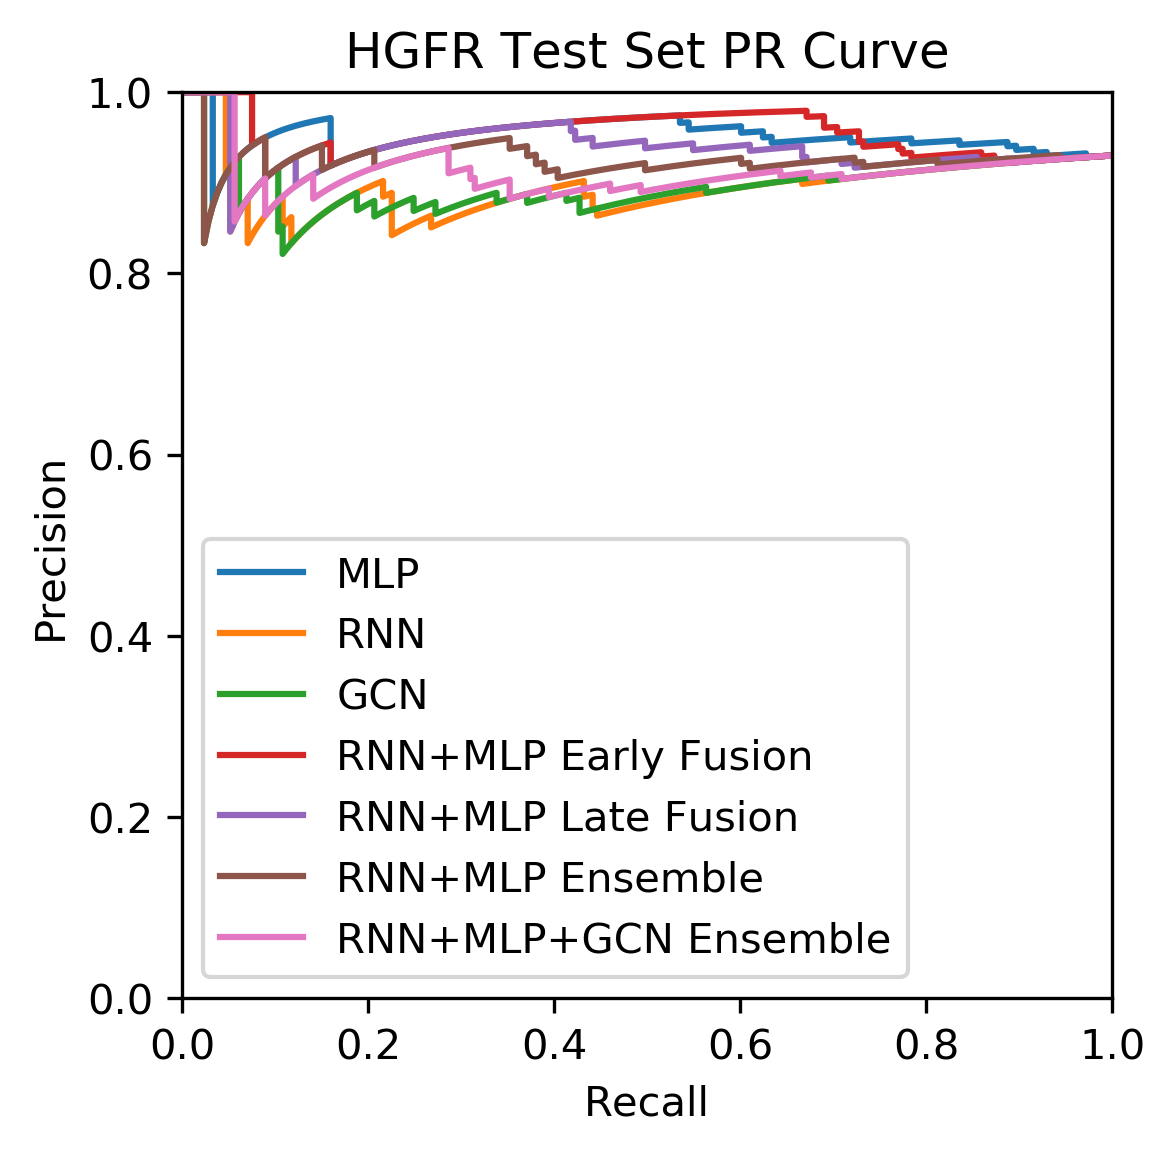

In [44]:
%matplotlib inline
fig2 = plt.figure(figsize=(4,4), dpi=300)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('%s Test Set PR Curve' % kinase.upper())
plt.xlim(0,1)
plt.ylim(0,1)
plt_mlp, = plt.plot(r_mlp_test, p_mlp_test, label='MLP')
plt_rnn, = plt.plot(r_rnn_test, p_rnn_test, label='RNN')
plt_gcn, = plt.plot(r_gcn_test, p_gcn_test, label='GCN')
plt_rnn_mlp_early, = plt.plot(r_mlp_rnn_early_test, p_mlp_rnn_early_test, label='RNN+MLP Early Fusion')
plt_rnn_mlp_late, = plt.plot(r_mlp_rnn_late_test, p_mlp_rnn_late_test, label='RNN+MLP Late Fusion')
plt_rnn_mlp_ens, = plt.plot(r_mlp_rnn_ens_test, p_mlp_rnn_ens_test, label='RNN+MLP Ensemble')
plt_rnn_mlp_gcn_ens, = plt.plot(r_mlp_rnn_gcn_ens_test, p_mlp_rnn_gcn_ens_test, label='RNN+MLP+GCN Ensemble')
plt.legend(handles=[plt_mlp, plt_rnn, plt_gcn, plt_rnn_mlp_early, plt_rnn_mlp_late, plt_rnn_mlp_ens, plt_rnn_mlp_gcn_ens])
fig2.savefig(os.path.join('curves', kinase + '_PR.png'), bbox_inches='tight')
plt.show()